# Lab 3 - Filter banks

Explore the design of filter banks, first designing the bandpass filters and building a filter bank structure that is able to obtain a perfect reconstruction of a sound.

## References:

### Low-pass filter
A low-pass filter is a filter that passes signal components with frequencies lower than a selected cutoff frequency and attenuates signal components with frequencies higher than the cutoff frequency.

### firwin
Algorithm in `scipy.signal`to perform an FIR filter design using the window method. This involves designing an ideal filter in the frequency domain and then applying a window function to smooth the frequency response and limit the number of taps (filter order).

### Bandpass filter
A band-pass filter is a filter that passes frequencies within a certain range and rejects (attenuates) frequencies outside that range. It's the opposite of a band-stop filter.

### Impulse response of a filter
A filter's impulse response function is simply the output of the filter when the input is an impulse of amplitude 1 at time zero.

### Frequency response of a filter
The frequency response of a filter is computed by taking the Fourier Transform of the impulse response and tells us how the filter affects the magnitudes and phases of the frequencies of a signal.

### Filter bank structure
An array of bandpass filters that separates the input signal into multiple components, each one carrying a sub-band of the original signal.

### Perfect reconstruction
Coding/decoding with which we recover the origianl sound identically.

### Critical sampling
In audio coding, critical sampling means that the encoding representation is of the same size than the original signal.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io.wavfile import read
from scipy.fft import fft
from scipy import signal as signal

In [12]:
# functions used in the whole lab
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

def display_spectrum(sound_array, sampling_rate=44100):
  """ Display magnitude spectrum of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # compute the hanning window
  window = signal.get_window('hann', sound_array.size)
  # compute the spectrum of the windowed input signal
  spectrum = fft(window*sound_array)
  # compute the magnitude spectrum in dB
  magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))

  # plot the magnitude spectrum
  plt.figure(0, figsize=(10, 5))
  frequency_indexes = np.arange(0, sampling_rate/2, sampling_rate/spectrum.size)
  plt.plot(frequency_indexes, magnitude_spectrum)
  plt.xlabel('frequency (Hz)')
  plt.ylabel('amplitude (dB)')
  plt.show()

def display_spectrogram(sound_array, hop_size=256, fft_size=512, sampling_rate=44100):
  """ Display magnitude spectrogram of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      hop_size (int): window hop size
      fft_size (int): Spectrogram fft size
      sampling_rate (int): Sampling rate of sound
  """
  # compute the hanning window
  window = signal.get_window('hann', fft_size)
  # initialize the output spectrogram
  magnitude_spectrogram = []
  sample_index = 0
  # iterate over the input sound computing a sequence of spectra
  while sample_index < sound_array.size-fft_size:
    spectrum = fft(window*sound_array[sample_index:sample_index+fft_size])
    magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))
    magnitude_spectrogram.append(magnitude_spectrum)
    sample_index += hop_size

  # plot the magnitude sspectrogram
  plt.figure(figsize=(10, 5))
  time_indexes = np.arange(0, sample_index/sampling_rate, hop_size/sampling_rate)
  frequency_indexes = np.arange(0, sampling_rate/2, sampling_rate/fft_size)
  plt.pcolormesh(time_indexes, frequency_indexes, np.transpose(magnitude_spectrogram), shading='nearest', cmap='inferno')
  plt.colorbar(format='%+2.0f dB')
  plt.xlabel('time (seconds)')
  plt.ylabel('frequency (Hz)')
  plt.show()

def plot_freq_response(w, h, title):
  "Utility function to plot frequency response functions"
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(111)
  ax.plot(w, 20*np.log10(np.abs(h)))
  ax.set_ylim(-80, 5)
  ax.grid(True)
  ax.set_xlabel('Frequency (Hz)')
  ax.set_ylabel('Gain (dB)')
  ax.set_title(title)

def prototype_filter(N, L):
  """ Generate a prototype FIR low-pass filter using a window method.
    Args:
      N (int): length of filter
      L (int): number of subbands
    Returns:
      Coefficients of the resulting FIR filter
  """
  return signal.firwin(N, 1.0 / (2 * L), window='hamming')

def modulate_filter(h, M, k):
    # Modulate the prototype filter
    n = np.arange(len(h))
    modulation = 2 * np.cos(np.pi * (2 * k + 1) * (n - (len(h) - 1) / 2) / (2 * M))
    return h * modulation

def analysis_filter_bank(x, M, N):
    # Analysis Filter Bank using Polyphase Decomposition
    h = prototype_filter(N, M)
    subband_length = len(x) // M
    subbands = np.zeros((M, subband_length))

    for k in range(M):
        hk = modulate_filter(h, M, k)
        filtered_signal = signal.lfilter(hk, 1.0, x)
        # Ensure the subband length matches the expected size
        downsampled_signal = filtered_signal[::M]
        if len(downsampled_signal) > subband_length:
            subbands[k] = downsampled_signal[:subband_length]
        else:
            subbands[k, :len(downsampled_signal)] = downsampled_signal

    return subbands

def synthesis_filter_bank(subbands, M, N):
    # Synthesis Filter Bank using Polyphase Decomposition
    h = prototype_filter(N, M)
    y_reconstructed = np.zeros(M * len(subbands[0]))

    for k in range(M):
        hk = modulate_filter(h, M, k)
        upsampled_signal = np.zeros(len(y_reconstructed))
        upsampled_signal[::M] = subbands[k]  # Upsample by M
        y_reconstructed += signal.lfilter(hk, 1.0, upsampled_signal)

    return y_reconstructed

## Part 1 - Low-pass filtering

Design a low-pass filter using the window method, `firwin` algorithm, and filter a sound with it. Answer the questions given and modify the code to support your answers.

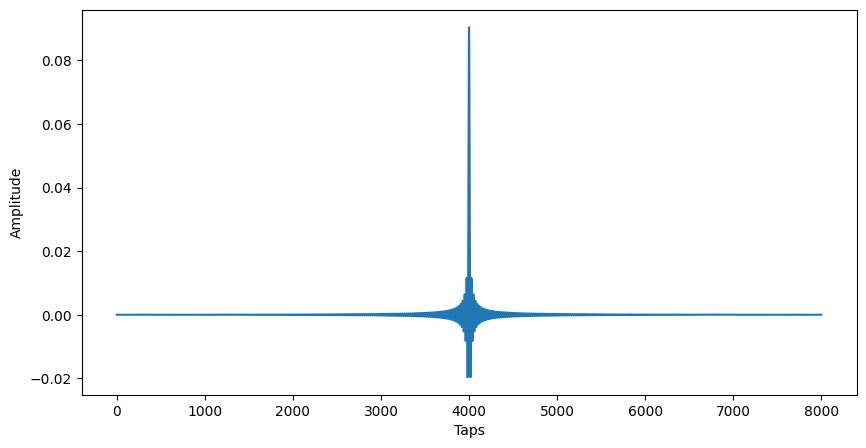

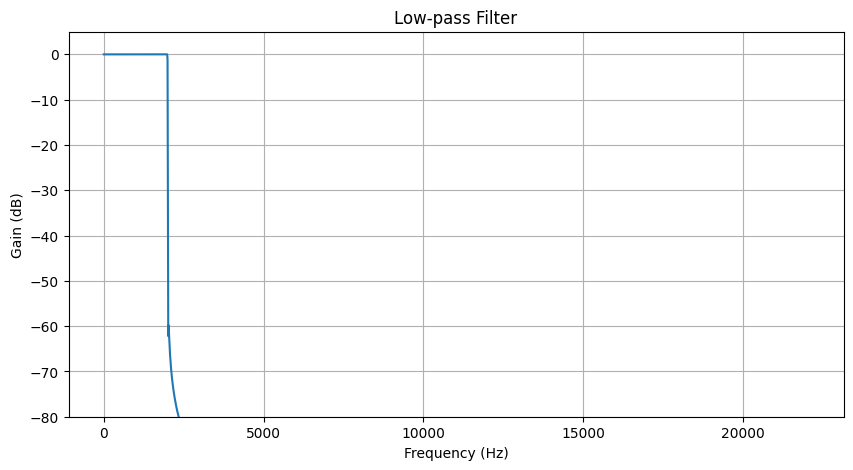

In [28]:
# design a low pass filter
fs = 44100.0
filter_length = 8000
cutoff = 2000
h = signal.firwin(filter_length, cutoff, window='hamming', fs=fs)

# plot impulse response of filter
plt.figure(figsize=(10, 5))
plt.plot(h)
plt.xlabel('Taps')
plt.ylabel('Amplitude')
plt.show()

# plot frequency response of filter
w, H = signal.freqz(h, [1], worN=2000, fs=fs)
plot_freq_response(w, H, "Low-pass Filter")
plt.show()

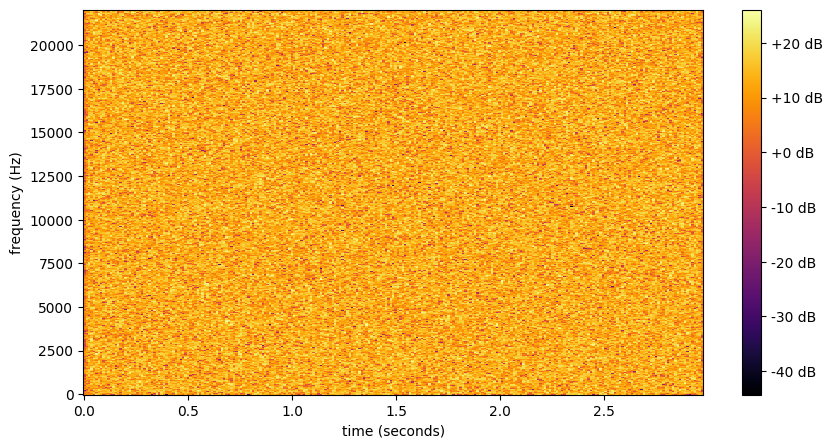

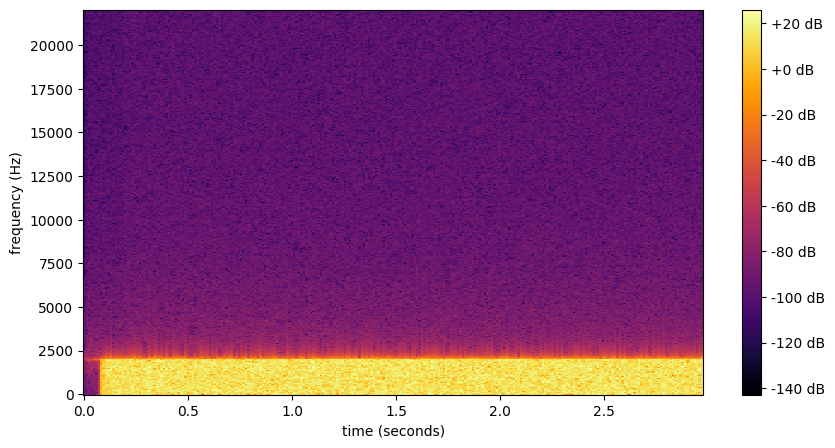

In [29]:
# filter a sound with the lowpass filter
sound_array, sampling_rate = read_sound('../sounds/white-noise.wav')
# apply filter by convolving the sound with the impulse response of filter
filtered_sound = signal.lfilter(h, 1, sound_array)
# display original sound
ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))
display_spectrogram(sound_array, 512, 1024, sampling_rate)
# display filtered sound
ipd.display(ipd.Audio(data=filtered_sound, rate=sampling_rate))
display_spectrogram(filtered_sound, 512, 1024, sampling_rate)

**Questions:**

**1. Design a lowpass filter with cutoff frequency of 2000Hz, using the `firwin` algorithm with different values for filter-length. Try values of 8, 800, 8000. Show the frequency responses and explain the differences.**

**Filter Length 8:** The frequency response shows that the cutoff is not well-defined, and there is a large amount of leakage (undesired signal) in both the passband and stopband. The filter is too short to efficiently attenuate frequencies above 2000 Hz, and it passes through a broader range of frequencies than desired.

**Filter Length 800:** The frequency response is sharper compared to the length of 8. The transition between the passband and stopband is more distinct, and there is better attenuation of frequencies above 2000 Hz. However, some small ripples remain.

**Filter Length 8000:** The frequency response is very sharp, with a steep cutoff and minimal ripples. The transition from passband to stopband is narrow, and the attenuation in the stopband is much better, meaning frequencies above 2000 Hz are strongly suppressed. This provides the most accurate filtering of the three.

As the filter length increases, the frequency response becomes more precise, with sharper transitions between passband and stopband, and better attenuation of unwanted frequencies. Longer filters allow more coefficients for more accurate modeling, but they introduce more delay (longer impulse responses) and increased computational complexity.

**2. Filter the sound `white-noise.wav` with the filters designed in question 1. Listen and explain the results, supporting it by showing the spectrograms of the filtered sounds.**

**Filter Length 8:** The sound filtered with this short filter still contains a lot of high-frequency content, because the filter isn't strong enough to remove those frequencies effectively. We can notice this fact when playing the audio and looking at the spectogram, in which we can see how only a thin line of frequencies is supressed (15000Hz).

**Filter Length 800:** This filter produces a smoother sound with more high-frequency content removed, as it has a sharper cutoff and better attenuation. The spectrogram shows more attenuation of the higher frequencies (above 2000 Hz), with the lower frequencies preserved.

**Filter Length 8000:** This filter outputs a very similar result to the filter with length 800. It also removes the most high-frequency content, making the sound smoother and softer due to the strong attenuation beyond the 2000 Hz cutoff. The noticeable difference is that a short time delay is introduced. The spectrogram is also similar, showing a sharp distinction between the preserved low frequencies and the highly attenuated high frequencies, and how at the first milliseconds there's no presence of any frequency. 

---

## Part 2 - Bank of bandpass filters

Design a bank of band-pass filters and apply it to a sound. Answer the questions given and modify the code to support your answers.

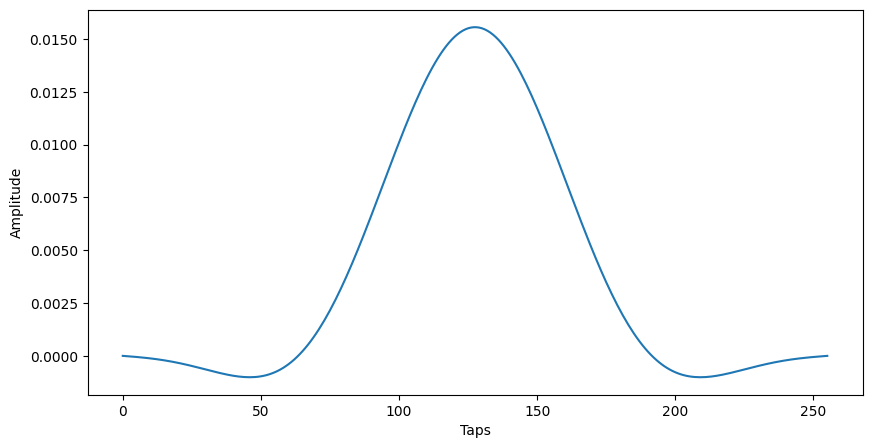

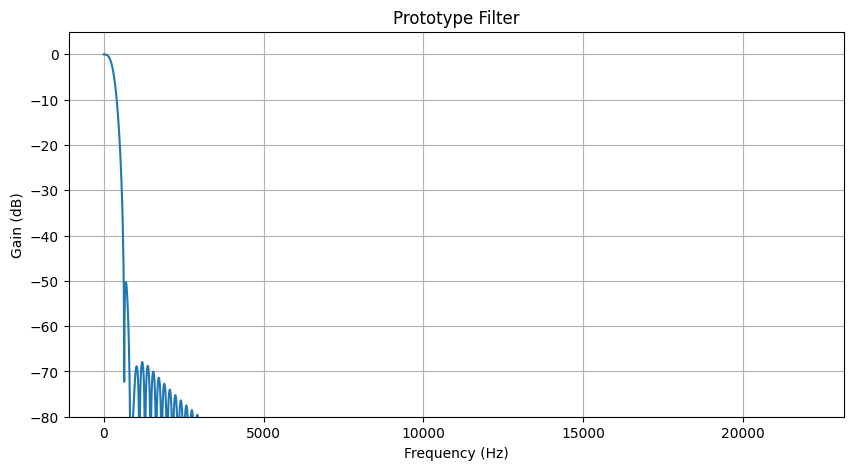

<Figure size 1000x500 with 0 Axes>

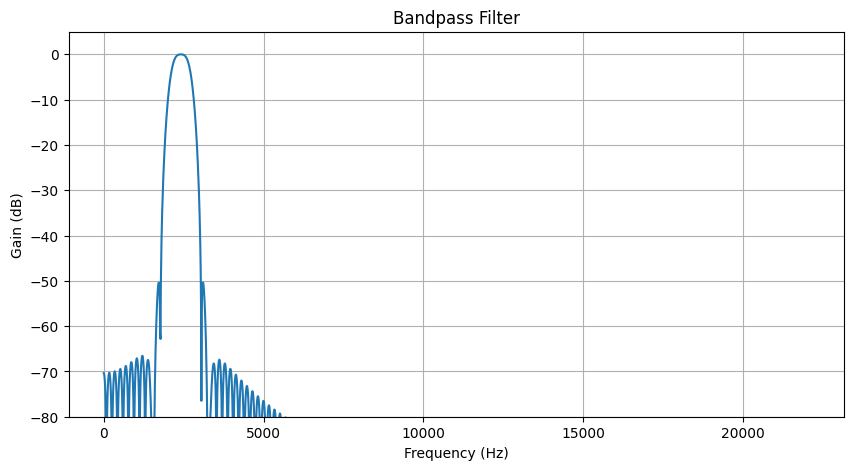

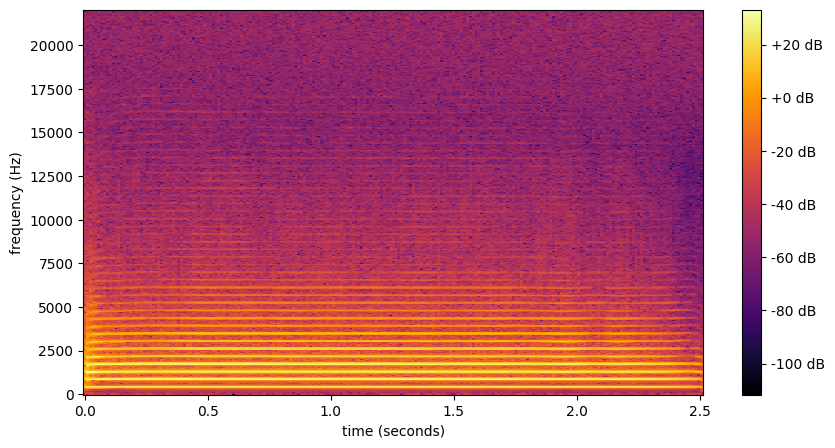

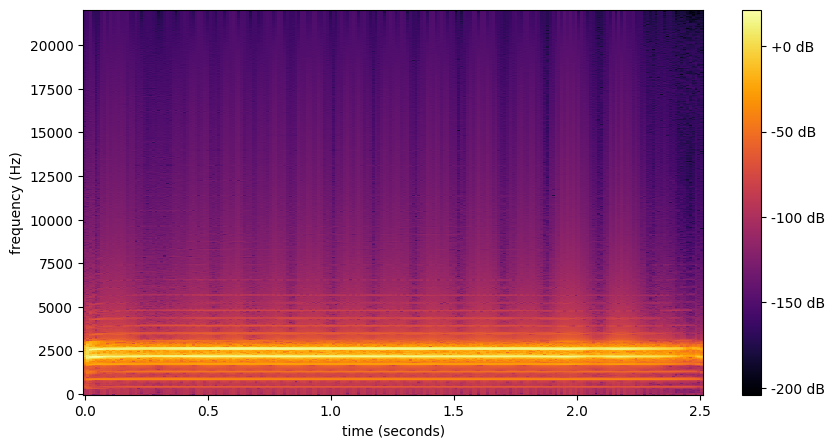

In [30]:
# Parameters for the filter bank
N = 256     # Length of the prototype filter
L = 32      # Number of subbands
fs = 44100  # Sampling rate

# Generate the prototype filter
h = prototype_filter(N, L)

# Plot the prototype filter
plt.figure(figsize=(10, 5))
plt.plot(h)
plt.xlabel('Taps')
plt.ylabel('Amplitude')

w, H = signal.freqz(h, [1], worN=2000, fs=fs)
plot_freq_response(w, H, "Prototype Filter")
plt.show()

# Create a bandpass filter
k = 3  # index of a band pass filter
hk = modulate_filter(h, L, k)

plt.figure(figsize=(10, 5))
w, H = signal.freqz(hk, [1], worN=2000, fs=fs)
plot_freq_response(w, H, "Bandpass Filter")
plt.show()

# filter a sound with the bandpass filter
sound_array, sampling_rate = read_sound('../sounds/487465-trumpet.wav')
# apply filter by convolving the sound with the impulse response of filter
filtered_sound = signal.lfilter(hk, 1, sound_array)
# display original sound
ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))
display_spectrogram(sound_array, 512, 1024, sampling_rate)
# display filtered sound
ipd.display(ipd.Audio(data=filtered_sound, rate=sampling_rate))
display_spectrogram(filtered_sound, 512, 1024, sampling_rate)


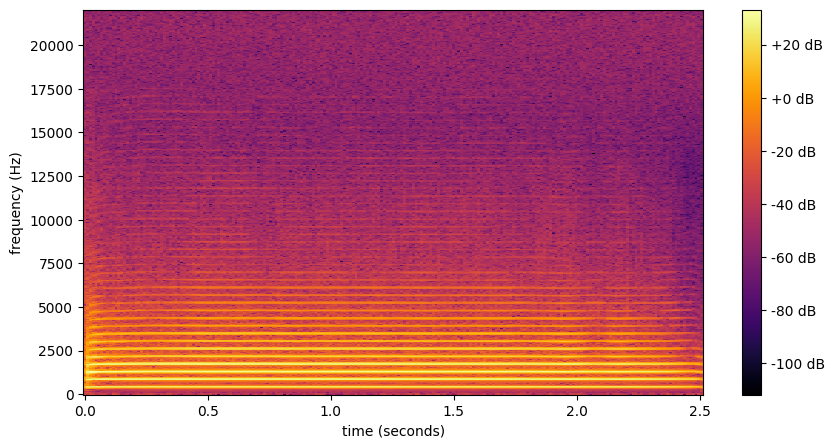

In [16]:
y = np.zeros(len(sound_array))

# apply the whole filter bank to a sound
for k in range(L):
  # Modulate prototype filter
  hk = modulate_filter(h, L, k)
  # Filter the signal
  filtered_sound = signal.lfilter(hk, 1, sound_array)
  y += filtered_sound

# display filtered sound
ipd.display(ipd.Audio(data=y, rate=sampling_rate))
display_spectrogram(y, 512, 1024, sampling_rate)

**Questions**
**1. Implement a low-pass filter and convert it to a band-pass filter. Explain how it works. Implement one example of a bandpass filter (define your own variables) and explain the result obtained when applying it to a particular sound (use one of the sounds in the sound directory).**

First, a low-pass filter is designed using the prototype_filter function with a specified length N = 256 and a number of subbands L = 32. It is converted into a bandpass filter by modulating it using the modulate_filter function, which shifts the filter's frequency response to the desired frequency range. The modulation creates a cosine signal that shifts the low-pass filter into the specified band (in this case, k = 3), determining the range of frequencies the bandpass filter allows through.

The spectrogram shows the effect of applying this bandpass filter to the sound (../sounds/487465-trumpet.wav). Only a specific band of frequencies is highlighted, corresponding to the passband of the filter (around 2500 Hz). Other frequency components outside this range are attenuated. 

**2. Implement a complete filter bank, apply it to the sound chosen in question 1 and try to get the best reconstruction by changing the size of the filters, N, and the number of filters, L. Explain the result.**

Each iteration of the loop generates a bandpass filter by modulating the prototype filter for a specific frequency band indexed by k, allowing us to isolate different frequency components of the input sound.

By summing the outputs from all filters, we attempt to reconstruct the original sound. The quality of this reconstruction depends on the filter parameters N and L. Increasing N improves the filter's sharpness, resulting in better frequency separation; however, it may also introduce computational cost. Increasing L results in more frequency bands, which can lead to a more detailed reconstruction of the sound, but may cause redundancy if the bands overlap.

With N = 256 and L = 32, the sound is effectively reconstructed. The spectrogram of the reconstructed sound is very similar to the original sound, as well as the perceived quality of the sound.

---

## Part 3 - Critical sampling
Experiment with critical sampling (the bandpass signals ocupy the same memory than the original signal), choosing the value L as the number of subbands, then downsampling each filtered band by L and finally upsampling them by L at the reconstruction stage.

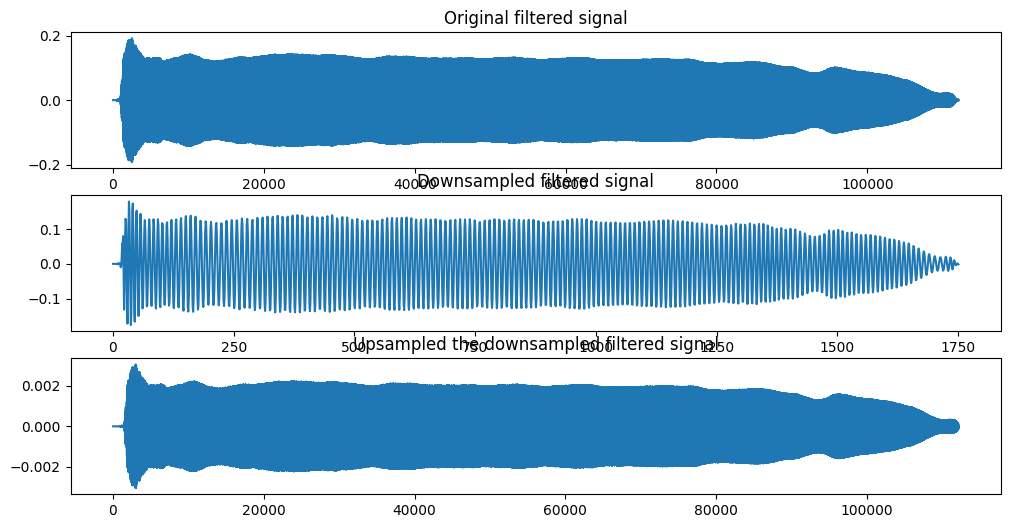

In [154]:
# downsample and upsample a filtered signal

# Parameters for the filter bank
N = 1024  # Length of the prototype filter
L = 64   # Number of subbands
fs = 44100  # Sampling rate

# Generate the prototype filter
h = prototype_filter(N, L)

# generate bandpass filter
k = 3
hk = modulate_filter(h, L, k)

# filter a sound with the bandpass filter
sound_array, sampling_rate = read_sound('../sounds/487465-trumpet.wav')

# Filter the signal
y = signal.lfilter(hk, 1.0, sound_array)
# down-sample the filtered signal
yd = y[::L]

# Upsample
yu = np.zeros(len(yd) * L)
yu[::L] = yd
# Filter with same filter than in encoding
yu = signal.lfilter(hk, 1.0, yu)

# Plot the original and reconstructed signals
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(y)
plt.title("Original filtered signal")
ipd.display(ipd.Audio(data=y, rate=sampling_rate))

plt.subplot(3, 1, 2)
plt.plot(yd)
plt.title("Downsampled filtered signal")
ipd.display(ipd.Audio(data=yd, rate=sampling_rate/L))

plt.subplot(3, 1, 3)
plt.plot(yu)
plt.title("Upsampled the downsampled filtered signal")
ipd.display(ipd.Audio(data=yu, rate=sampling_rate))
plt.show()

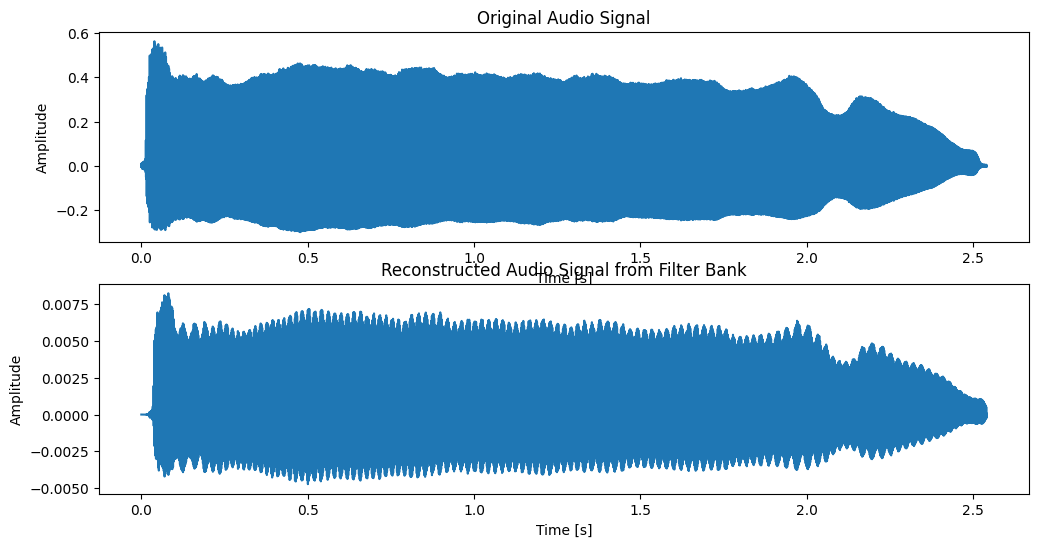

In [155]:
# encode and decode a signal with an bank of filters

# Parameters for the filter bank
# N = 1024  # Length of the prototype filter
# L = 10   # Number of subbands
# fs = 44100  # Sampling rate

sound_array, sampling_rate = read_sound('../sounds/487465-trumpet.wav')
t = np.linspace(0, len(sound_array)/sampling_rate, len(sound_array), endpoint=False)

# Analysis (encoding): split the signal into subbands
subbands = analysis_filter_bank(sound_array, L, N)

# Synthesis (decoding): reconstruct the signal from subbands
reconstructed_signal = synthesis_filter_bank(subbands, L, N)

# Plot the original and reconstructed signals
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, sound_array)
plt.title("Original Audio Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

plt.subplot(2, 1, 2)
plt.plot(t[:len(reconstructed_signal)],reconstructed_signal)
plt.title("Reconstructed Audio Signal from Filter Bank")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
ipd.display(ipd.Audio(data=reconstructed_signal, rate=sampling_rate))

plt.show()

In [156]:
# Code to check the size of the original signal and the size of the encoded subbands
original_size = len(sound_array)
encoded_size = len(reconstructed_signal)

print(f"Size of the original signal: {original_size}")
print(f"Size of the encoded subbands: {encoded_size}")

Size of the original signal: 112076
Size of the encoded subbands: 112064


**Questions:**

**1. Create a filter bank for L number of subbands. Apply it to a sound from the sounds directory while downsampling by L the subbands (encoded signal), then upsampling the subbands and addindg them together (decoded signal). Try to get the best reconstruction by trying different filter lengths (ex: 64, 128, 256). Explain the result.**

Increasing N enhances the filter's sharpness, resulting in a better approximation of the original signal due to improved frequency separation. However, this also introduces more delay. The optimal configuration observed was N = 1024 and L = 32, providing great sound quality despite some delay.

The choice of L affects the number of frequency bands into which the audio signal is divided. A higher L offers more frequency resolution, improving reconstruction quality, but can also lead to a less smooth waveform with amplitude irregularities. Conversely, a lower L may oversimplify the signal, resulting in a loss of detail

**2. Prove that the encoding process performs critical sampling, so the size of all the subbands (the encoded matrix) is equal to the size of the input signal. Add the needed code.**

If we compare the size of the original signal, which is 112,076 samples, to the size of the encoded subbands, which is 112,064 samples, we can extract that this close match indicates that the encoding process retains most of the original signal's information. The minimal difference of 12 samples shows effective critical sampling, where the encoded subbands occupy a similar amount of memory as the original signal, unlike other parameter values (different than the ones mentioned in the previous question) that resulted in more significant size discrepancies.

---